# Keeling Curve - Time Series 

Author: Harry Yau

This notebook will be investing time series forecasting using the Facebook Prophet package. https://facebook.github.io/prophet/. The dataset that will be utilized is the carbon dioxide (CO<sub>2</sub>) measurements from the Mauna Loa Observatory. This monitoring station has been recording data since 1958. This dataset is also known as the Keeling Curve, which is aptly named to the scientist Charles David Keeling, and is a graph that shows the accumulation of CO<sub>2</sub> in the atmosphere. The Keeling Curve is famous for bringing the attention of the increase in CO<sub>2</sub> concentrations in the atmosphere.

For more information about this Keeling Curve, please read the following Wikipedia page: https://en.wikipedia.org/wiki/Keeling_Curve

In [1]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet

#### Loading the Data

The data will be downloaded from this website: http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo. The monthly frequency will be used.

In [2]:
url = "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"

data = pd.read_csv(url, skiprows=56, na_values=-99.99)

#Change the column names. The column names on the data set spans two rows.
colname = ['Yr', 'Mn', 'Excel Date', 'Date', 'CO2 (PPM)', 'CO2 Seasonally Adjusted (PPM)', 
           'CO2 Fit (PPM)', 'CO2 Seasonally Adjusted Fit (PPM)', 'CO2 Filled (PPM)', 'CO2 Seasonally Adjusted Filled (PPM)']
data.columns = colname

In [3]:
data.head()

,Yr,Mn,Excel Date,Date,CO2 (PPM),CO2 Seasonally Adjusted (PPM),CO2 Fit (PPM),CO2 Seasonally Adjusted Fit (PPM),CO2 Filled (PPM),CO2 Seasonally Adjusted Filled (PPM)
0,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71


We will be using the column 'CO2 Filled (PPM)' as the monthly CO2 data. For a detailed explanation on the different columns of CO2's, please download the csv file and there is a detailed explanation between row 39 to 51.

#### Convert Dates to Time Stamp

In [4]:
data['TimeStamp'] = pd.to_datetime(data['Yr'].astype(str).str.cat(data['Mn'].astype(str), sep='-'))

#### Creating the DataFrame for Prophet

Fitting the function for Prophet requires the input DataFrame to have column names of 'ds' and 'y'.

- ds: A column with type timestamps
- y: The value that the timeseries forecasting will be based on

In [5]:
data_prophet = data.loc[:, ['TimeStamp', 'CO2 Filled (PPM)']].copy()
data_prophet.columns = ['ds', 'y']
data_prophet.dropna(inplace=True) #The 'filled' data is being used, so rows of NaN will only occur at the top and bottom of the dataset.
data_prophet.reset_index(drop=True, inplace=True)

In [6]:
data_prophet.head()

,ds,y
0,1958-03-01,315.70
1,1958-04-01,317.45
2,1958-05-01,317.51
3,1958-06-01,317.24
4,1958-07-01,315.86


#### Fitting the Prophet Model

In [7]:
keeling_model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
keeling_model.fit(data_prophet)

#### Forecasting using Prophet

We will be forecasting the Keeling Curve for 20 years in the future with a monthly frequency.

In [8]:
year = 20
fcst_period = year * 12

future_dates = keeling_model.make_future_dataframe(periods=fcst_period, freq='M')
keeling_fcst = keeling_model.predict(future_dates)

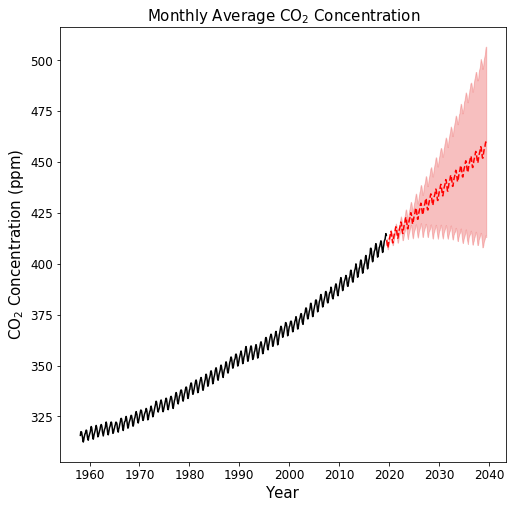

In [9]:
#Font Settings
font_size_title = 20
font_size_label = 15
font_size_tick = 12

#Grabbing the first index
first_idx = data_prophet.shape[0]

plt.figure(figsize=(8,8))

plt.fill_between(keeling_fcst['ds'][first_idx:], keeling_fcst['yhat_lower'][first_idx:], 
                 keeling_fcst['yhat_upper'][first_idx:], color='lightcoral', alpha = 0.5)
plt.plot(keeling_fcst['ds'][first_idx:], keeling_fcst['yhat'][first_idx:], color='red', linestyle ='dashed')
plt.plot(data_prophet['ds'].astype('datetime64'), data_prophet['y'], 'k-')
plt.xlabel('Year', fontsize=font_size_label)
plt.ylabel('CO$_2$ Concentration (ppm)', fontsize=font_size_label)
plt.title('Monthly Average CO$_2$ Concentration', fontsize=font_size_label);
plt.xticks(fontsize=font_size_tick)
plt.yticks(fontsize=font_size_tick)
plt.show();